<a href="https://colab.research.google.com/github/NatasaKinzy/Data-Science/blob/main/Unit5/NataKinzUnit5Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
import graphviz as gv

from scipy.interpolate import PchipInterpolator

# Penguin Culmen Length Vs Flipper Length



# Context



A penguin's culmen is basically its beak and their flippers are their little wings/arms that dont work as wings. Penguins are my favorite animal and the data set I wanted to do wasn't linear so here we are. I decided to analyze culmen length vs flipper length because I wanted to see if evolutionarily beak length correlated with flipper length.

Here are a few penguin pictures to make your day better :)

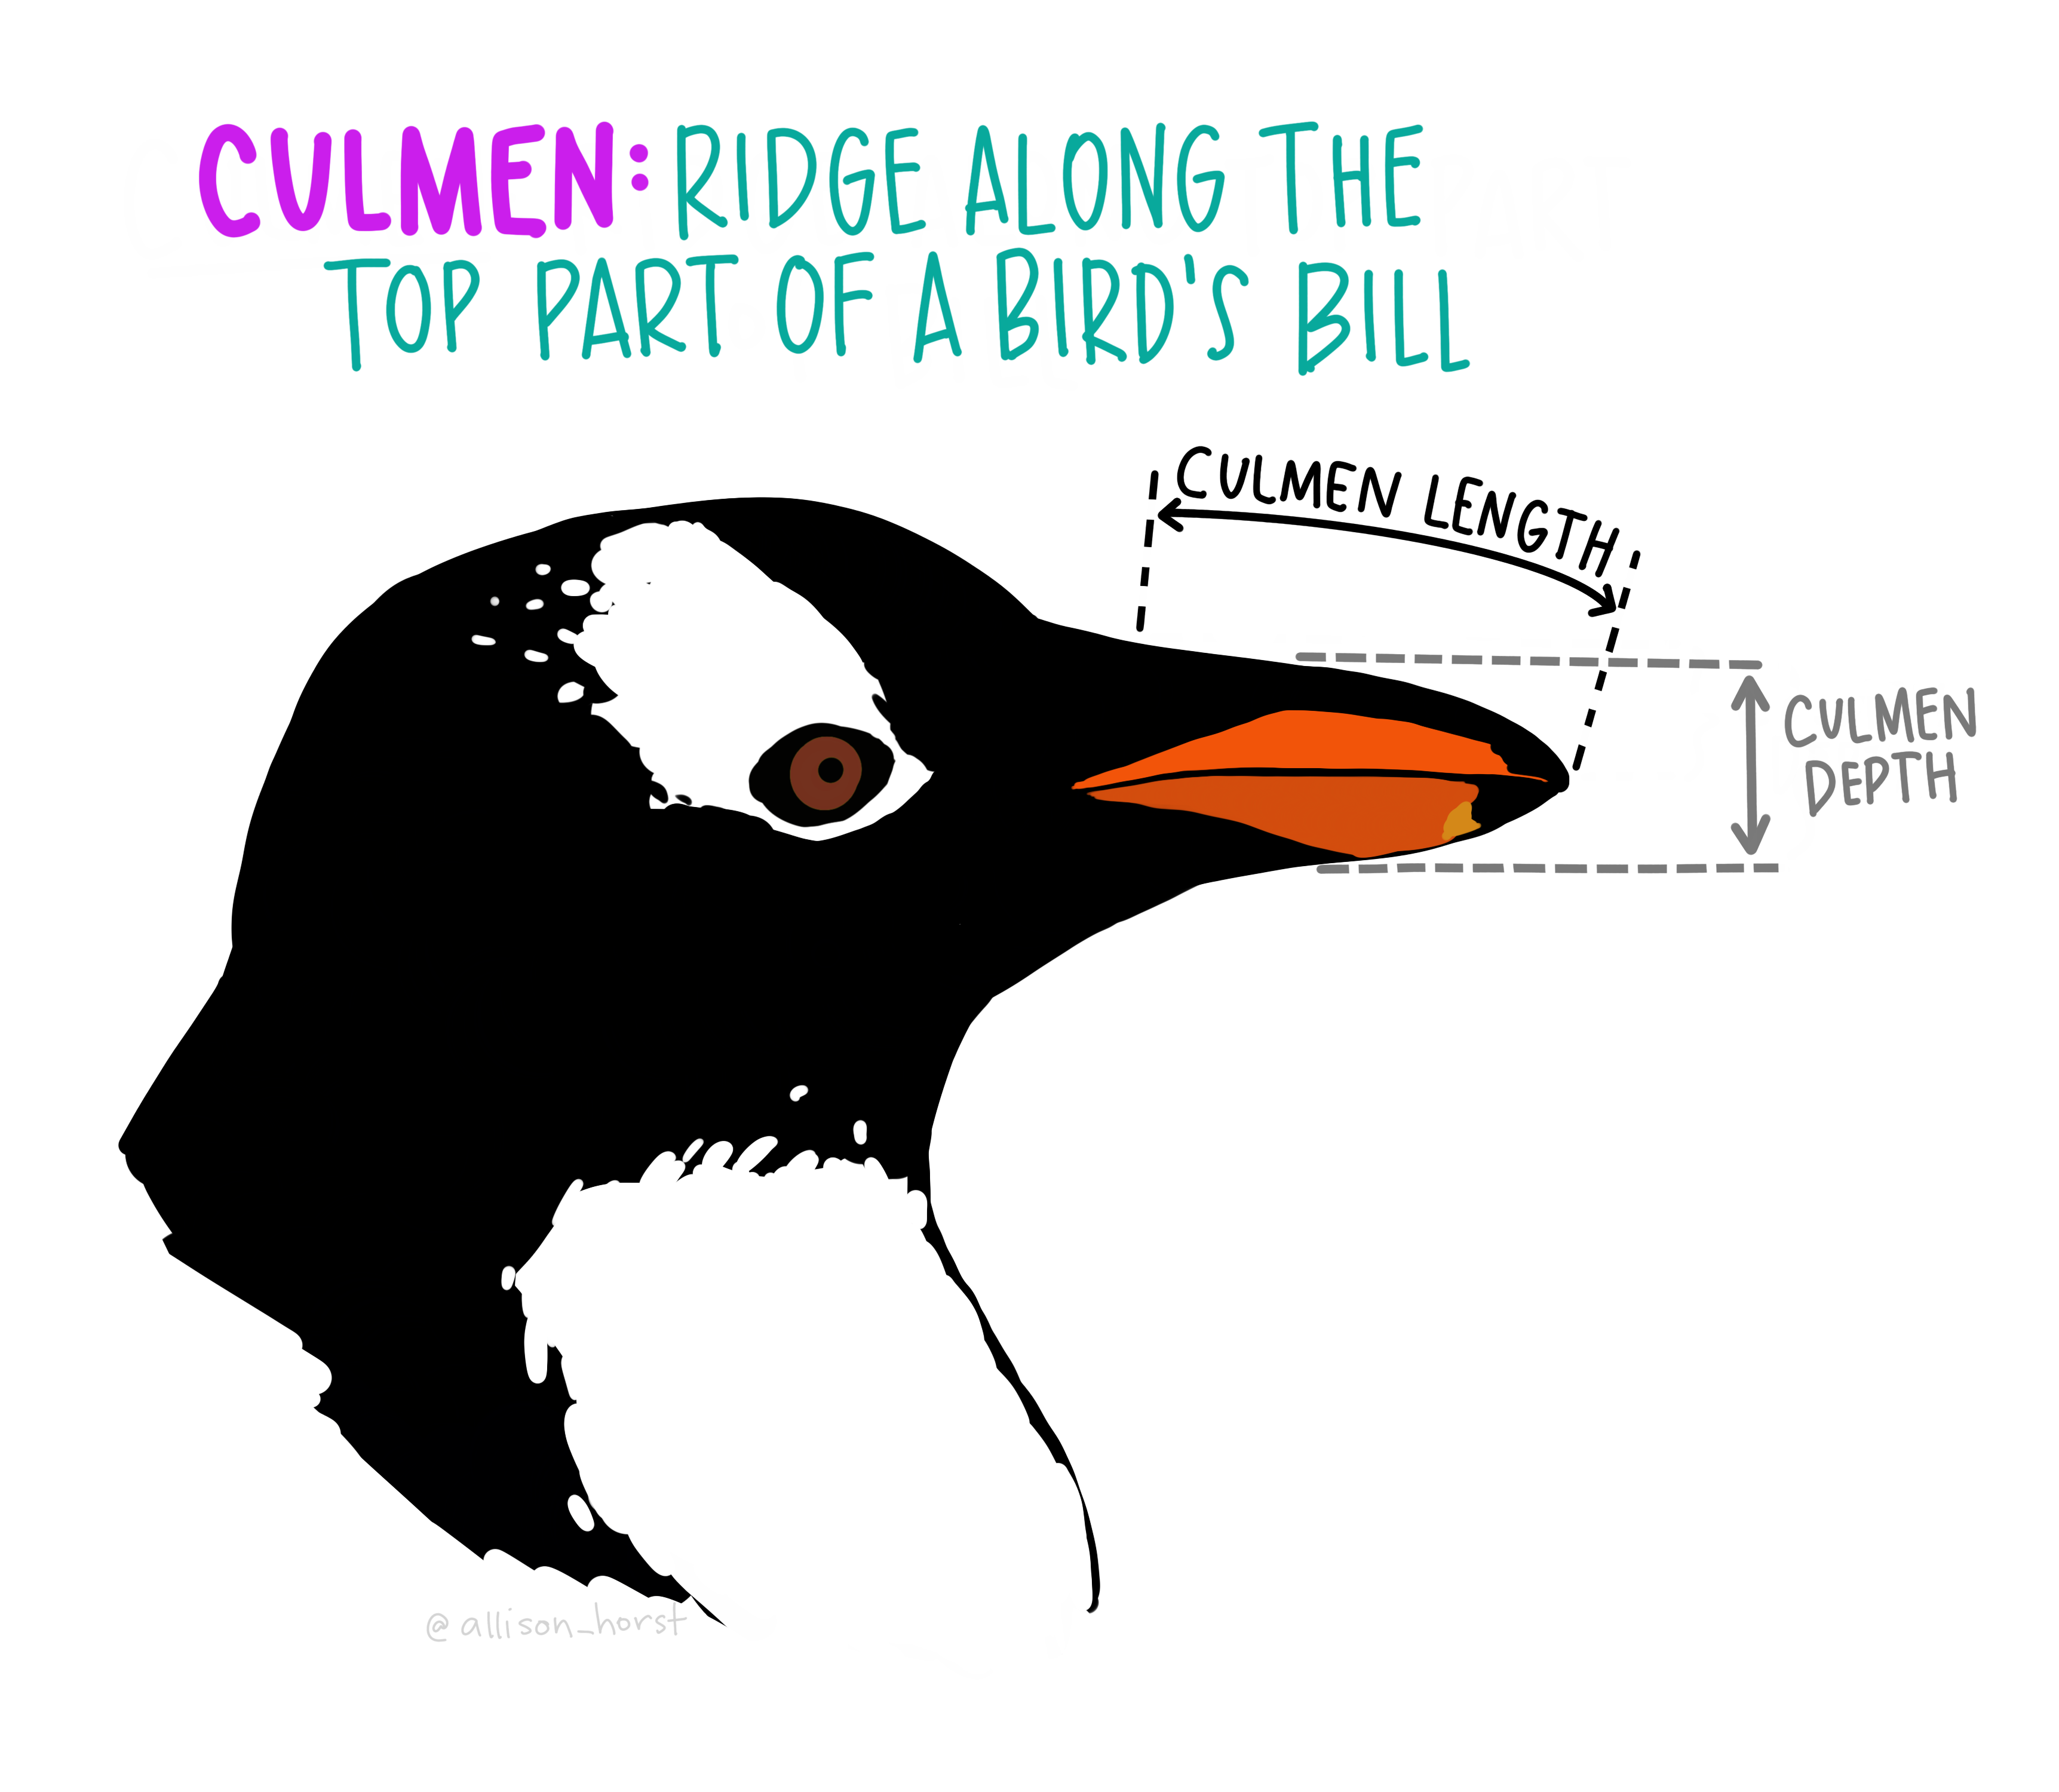

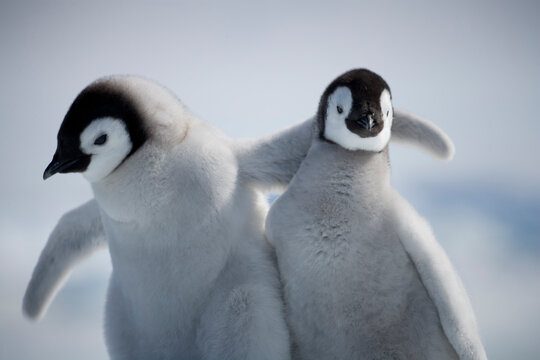

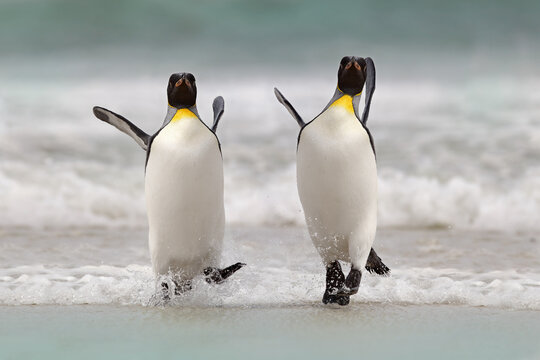

In [17]:
#BPC=Beer Per Capita
url_penguin = 'https://raw.githubusercontent.com/NatasaKinzy/Data-Science/refs/heads/main/goog4_request%26X-Goog-Date%3D20251210T190502Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D13ba44bbf5cd519efb88b245a8bc7714dffab23e564997a8aad9233a8666968165017c73c7c7aca780c0ca56b48b96a3c73fd28de1d52d28b3e3d83f25e55266bda1.csv'
penguin = pd.read_csv(url_penguin).dropna()

In [3]:
penguin

,culmen_length_mm
0,39.1
1,39.5
2,40.3
4,36.7
5,39.3
...,...
338,47.2
340,46.8
341,50.4
342,45.2


<Axes: xlabel='culmen_length_mm', ylabel='flipper_length_mm'>

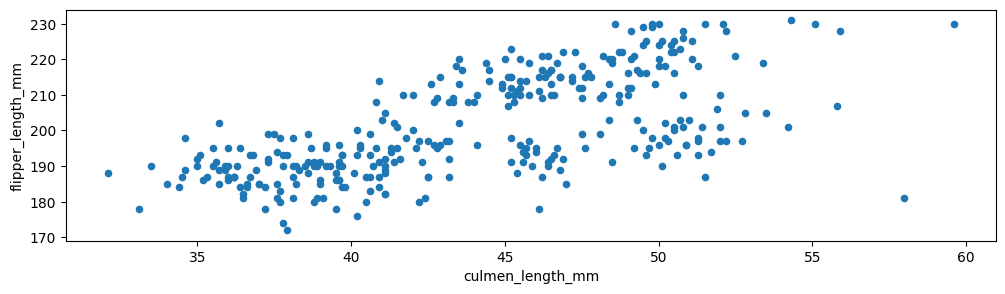

In [4]:
penguin.plot(x="culmen_length_mm", y="flipper_length_mm", figsize=(12, 3), kind="scatter")

In [ ]:

with pm.Model() as model_penguin:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * penguin.culmen_length_mm)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=penguin.flipper_length_mm)

    #inference data object
    idata_penguin = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_penguin, model=model_penguin,  extend_inferencedata=True)

Text(0, 0.5, 'flipper length')

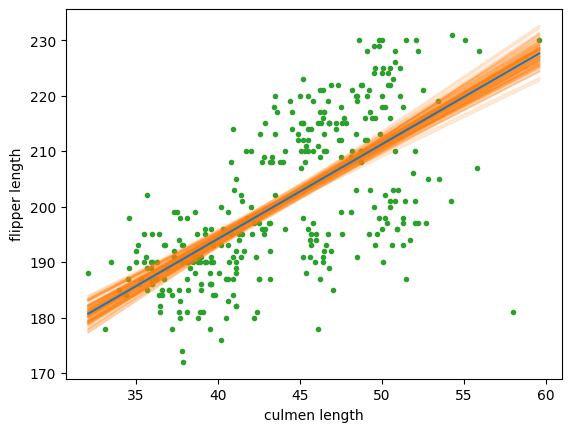

In [7]:
#grabs 100 posterior samples
posterior = az.extract(idata_penguin, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(penguin.culmen_length_mm.min(), penguin.culmen_length_mm.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(penguin.culmen_length_mm, penguin.flipper_length_mm, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("culmen length")
ax.set_ylabel("flipper length")

Text(0, 0.5, 'flipper length')

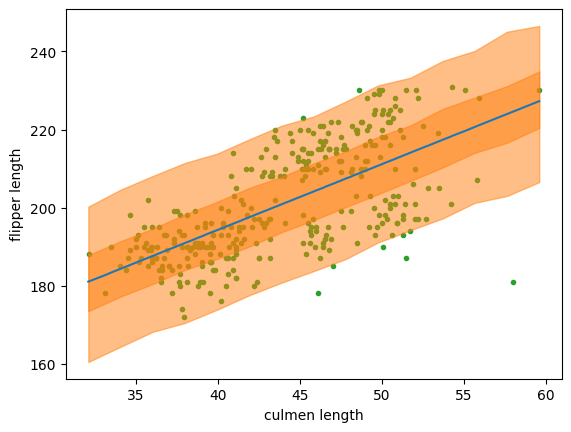

In [18]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_penguin.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
culmen_length_mm = np.random.normal(penguin.culmen_length_mm.values, 0.01)
idx = np.argsort(culmen_length_mm)
x = np.linspace(culmen_length_mm.min(), culmen_length_mm.max(), 15)

#grabs the 94% HDI and 50% HDI
y_pred_q = idata_penguin.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
#sets up the HDIs for graphing
y_hat_bounds = iter(
    [
        PchipInterpolator(culmen_length_mm[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(penguin.culmen_length_mm, penguin.flipper_length_mm, "C2.", zorder=-3)
ax.plot(culmen_length_mm[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("culmen length")
ax.set_ylabel("flipper length")

# Analysis

It seems that culmen length as compared to flipper length IS in fact linear and fully able to be represented by a linear model! WOW! Aren't we feeling so englightened...?

The linear model definitely doesn't represent it exactly, so I think a modification that could be made to my representation of this data could be with two different linear models. I fully believe the divergence in this data is due to some evolutionary distinguishing trait but I don't know what it could be based on the data I have. Also, just to be clear, I think my current linear model is *ok* at reprensenting the data but if it were two separate linear models it could show that divergence and represent the trend/data much better.

Now although they seem to be directly related, the data is simultaniously separated into what looks like three distinct zones: lower left, lower right, and upper right. I'm not really sure why it has separated into these distinct sections, but Mr. Arredondo said we would find out in a unit or two so I suppose this is just a precursor to the future knowledge we have yet to gain. I think its because once culmen length surpasses 43, the relationship between culmen length and flipper length reaches a kind of fork in the road where evolutionarily some penguins have x rate of change and some others have y rate of change. I wonder if some other factor such as age, weight, species, sex, etc is what contributes to this difference.

One other pattern I noticed is that there is a kind of blank space between a flipper length of 200-210mm and 41-60mm of culmen length. I have absolutely no idea why this could be so I imagine I'll have to look into penguins more to understand why. It seems though that within those ranges the direct relationship between these two lowkey disappears.

Lastly, my biggest hardship while creating this model was getting the posterior predictive distribution to run, but I learned something! Basically, in the case of this specific code for this specific posterior predictive distribution, "culmen_length_mm" calls a "jitter" data point. This means that it calls something either above or below the original data point so that it can craft an accurate estimation of the upper and lower bounds of the orange shading. In constrast, "penguin.culmen_length_mm" is the original dataset used to craft the distribution and model. I didn't understand this difference and used "penguin." every time I used "culmen_length_mm" which ended up resulting in a confused computer and even more confused me. So basically, I just needed to know what distinguished these two commands because once that was fixed the model stopped being confused and it ran :)

I hope you enjoyed my pictures of penguins and attempts at making "interesting" (interesting is subjective, and in my opinion it would have been more fun to discover no correlation between beer consumption per capita and distance from Lexor, Egypt, but that's alright I suppose) data!